In [1]:
import os
import re
import json
import time
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import scikitplot as skplt

import featuretools as ft

from glob import glob
from datetime import datetime, date, timedelta
from collections import Counter
from tqdm import tqdm_notebook

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

In [2]:
continuous_features = joblib.load('data/iterables/continuous_features.joblib')
categorical_features = joblib.load('data/iterables/categorical_features.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')

In [3]:
df_all = pd.read_pickle('data/df/df_all.pkl')
df_all.shape

(488189, 100)

In [4]:
df_all.reset_index(drop=True, inplace=True)

In [5]:
y = df_all.groupby(["resort_id"])["amount_spent_per_room_night_scaled"].agg(['mean']).values.flatten()

In [6]:
gdf = df_all.groupby(["resort_id", "cat_checkout_date_day"])["total_pax"].agg(["max", "mean", "std", "count", "skew"]).reset_index()

In [7]:
features_filtered_direct = extract_features(gdf, column_id='resort_id', column_sort='cat_checkout_date_day', disable_progressbar=True)

In [8]:
impute(features_filtered_direct);

 'count__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'count__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...
 'std__fft_coefficient__coeff_99__attr_"angle"'
 'std__fft_coefficient__coeff_99__attr_"imag"'
 'std__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


In [9]:
features_drop = [c for c in features_filtered_direct.columns if len(features_filtered_direct[c].unique()) == 1]
if features_drop.__len__() > 0:
    features_filtered_direct.drop(features_drop, axis=1, inplace=True)

In [10]:
features_filtered_direct.reset_index(inplace=True)

In [11]:
features_filtered_direct.to_pickle('data/df/features_filtered_direct.pkl')

In [5]:
features_filtered_direct = pd.read_pickle('data/df/features_filtered_direct.pkl')

In [6]:
df_all = df_all.merge(features_filtered_direct, how='inner', left_on='resort_id', right_on='id')

In [7]:
df_all.shape

(488189, 1810)

In [8]:
cont_ft_features = features_filtered_direct.columns.tolist()
cont_ft_features.remove('id')

In [9]:
categorical_features = categorical_features
print("#{} of categorical features".format(categorical_features.__len__()))

continuous_features = continuous_features + cont_ft_features
print("#{} of continuous features".format(continuous_features.__len__()))

#36 of categorical features
#1767 of continuous features


In [10]:
joblib.dump(categorical_features, 'data/iterables/categorical_features_with_ft.joblib')
joblib.dump(continuous_features, 'data/iterables/continuous_features_with_ft.joblib')

['data/iterables/continuous_features_with_ft.joblib']

In [11]:
df_all.to_pickle('data/df/df_all_with_ft.pkl')

## Enter FeatureTools

In [ ]:
entities = [
    ('cdd', 'cat_checkout_date_day'),
]

In [ ]:
joblib.dump(entities, 'data/iterables/entities.joblib');

In [ ]:
es = ft.EntitySet()
for ent, ent_id in entities:
    df = pd.DataFrame(df_all[ent_id].unique(), columns=[ent_id])
    es = es.entity_from_dataframe(entity_id=ent,dataframe=df, index=ent_id)
es.plot()

In [ ]:
cols_feature_target = [c for _, c in entities]
cols_feature_target.extend(['total_pax'])

In [ ]:
variable_types = dict()
for _, c in entities:
    variable_types[c] = ft.variable_types.Categorical

variable_types['total_pax'] = ft.variable_types.Numeric

In [ ]:
assert(len(cols_feature_target) == len(variable_types))

In [ ]:
df_all.reset_index(drop=True, inplace=True)
df_all['reservation_index'] = df_all.index
es = es.entity_from_dataframe(entity_id="reservations", dataframe=df_all[cols_feature_target + ['reservation_index']], index="reservation_index", variable_types=variable_types)
es.plot()

In [ ]:
for ent, ent_id in entities:
    es = es.add_relationship(ft.Relationship(es[ent][ent_id], es["reservations"][ent_id]))
es.plot()

In [ ]:
# es['reservations']['resort_id'].interesting_values = df_all['resort_id'].unique().tolist()

In [ ]:
es

In [ ]:
MAX_DEPTH, N_JOBS = 2, 8
agg_primitives = ["std", "max", "mean", "count", "skew"]
where_primitives = []
trans_primitives = []

cols_f1 = []

In [ ]:
for te, _ in entities:
    if not os.path.isdir(os.path.join('data', 'ft', te)):
        os.mkdir(os.path.join('data', 'ft', te))
        os.mkdir(os.path.join('data', 'ft', te, 'drop'))
        os.mkdir(os.path.join('data', 'ft', te, 'use'))
        continue
    else:
        if not os.path.isdir(os.path.join('data', 'ft', te, 'drop')):
            os.mkdir(os.path.join('data', 'ft', te, 'drop'))
        if not os.path.isdir(os.path.join('data', 'ft', te, 'use')):
            os.mkdir(os.path.join('data', 'ft', te, 'use'))

In [ ]:
ft_cols = {te : dict() for te, _ in entities}
features = {te : dict() for te, _ in entities}
for te, te_id in tqdm_notebook(entities):
    
    ft_cols[te]['id'] = te_id
    features[te]['id'] = te_id
    
    while True:
        print("Using entities as #{}".format(te))
        
        drop_exact = list()
        for features_drop_joblib in glob(os.path.join('data', 'ft', te, "drop", "*.joblib")):
            drop_exact.extend(joblib.load(features_drop_joblib))
        for features_drop_joblib in glob(os.path.join('data', 'ft', te, "use", "*.joblib")):
            drop_exact.extend(joblib.load(features_drop_joblib))   
        
        drop_exact = list(set(drop_exact))
        print("Dropping #{} exact features".format(drop_exact.__len__()))

        try:
            features[te]['features'], features[te]['defs'] = ft.dfs(entityset=es, target_entity=te, agg_primitives=agg_primitives, where_primitives=where_primitives, 
                                    trans_primitives=trans_primitives, max_depth=MAX_DEPTH, n_jobs=N_JOBS, verbose=True, 
                                    drop_exact=drop_exact, max_features=-1)
        except AssertionError as ex:
            print("AssertionError @{}".format(repr(ex)))
            break
        except Exception as ex:
            print("Exception @{}".format(repr(ex)))
            continue

        # always break
        break_out = True
        if features[te]['features'].shape[1] < 512:
            break_out = True
            
        # joblib all single values
        features[te]['features'].fillna(0.0, inplace=True)
        features_drop = [c for c in features[te]['features'].columns if len(features[te]['features'][c].unique()) == 1]
        if features_drop.__len__() > 0:
            joblib.dump(features_drop, os.path.join('data', "ft", te, "drop", "single_features_drop_{}.joblib".format(datetime.now().strftime("%Y%m%d%H%M%S"))))
            features[te]['features'].drop(features_drop, axis=1, inplace=True)

        cat_ft =  [c1 for c1 in features[te]['features'].columns if any([c2 for c2 in cols_f1 if c2 in c1])]
        cont_ft = [c for c in features[te]['features'].columns if c not in cat_ft] 

        print("\nIdentified #{} categorical and #{} continuous features".format(cat_ft.__len__(), cont_ft.__len__()))

        ft_cols[te]['categorical_features'] = cat_ft
        ft_cols[te]['continuous_features'] = cont_ft
    
        features[te]['features'].columns = ["{}_{}".format(c, te) for c in features[te]['features'].columns]
        
        cat_ft_new = [c1 for c1 in features[te]['features'].columns if any([c2 for c2 in cols_f1 if c2 in c1])]
        cont_ft_new = [c for c in features[te]['features'].columns if c not in cat_ft_new]
        
        features[te]['categorical_features'] = cat_ft_new
        features[te]['continuous_features'] =  cont_ft_new
    
        if break_out:
            break

In [ ]:
# joblib.dump([c.replace('_rid', '') for c in features['rid']['features'].columns if 'COUNT(reservations WHERE resort_id' in c], 'data/ft/rid/drop/drop1.joblib')

In [ ]:
features[te]['features'].reset_index(inplace=True)

In [ ]:
features[te]['features']['bias'] = 1

In [4]:
from tsfresh import extract_features
extracted_features = extract_features(features[te]['features'], column_id="bias", column_sort="cat_checkout_date_day")

NameError: name 'features' is not defined

In [25]:
features[te]['features'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
cat_checkout_date_day               31 non-null int64
STD(reservations.total_pax)_cdd     31 non-null float64
MAX(reservations.total_pax)_cdd     31 non-null int64
MEAN(reservations.total_pax)_cdd    31 non-null float64
COUNT(reservations)_cdd             31 non-null int64
SKEW(reservations.total_pax)_cdd    31 non-null float64
bias                                31 non-null int64
dtypes: float64(3), int64(4)
memory usage: 1.8 KB


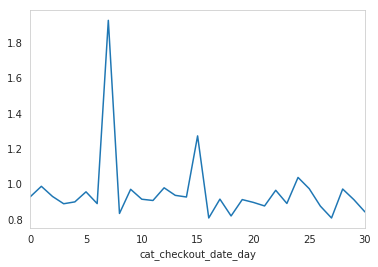

In [119]:
features[te]['features']['SKEW(reservations.total_pax)_cdd'].plot()

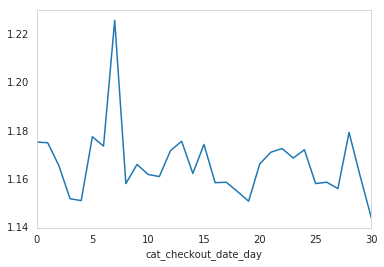

In [120]:
features[te]['features']['STD(reservations.total_pax)_cdd'].plot()

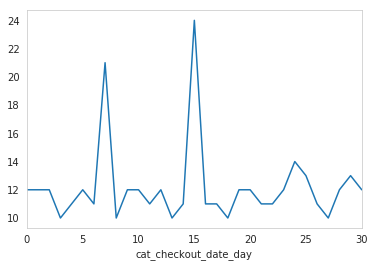

In [121]:
features[te]['features']['MAX(reservations.total_pax)_cdd'].plot()

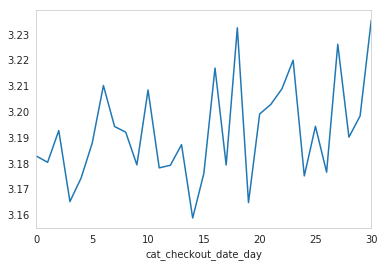

In [122]:
features[te]['features']['MEAN(reservations.total_pax)_cdd'].plot()

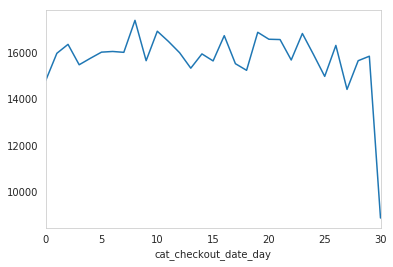

In [123]:
features[te]['features']['COUNT(reservations)_cdd'].plot()

In [56]:
joblib.dump(ft_cols, 'data/iterables/ft_cols.joblib');

In [22]:
cat_ft_features, cont_ft_features = list(), list()
for te, te_features in tqdm_notebook(features.items()):
    cat_ft_features.extend(te_features['categorical_features'])
    cont_ft_features.extend(te_features['continuous_features'])
    
    ft.save_features(te_features['defs'], "data/ft/{}.ft".format(te))

In [23]:
joblib.dump(cat_ft_features, 'data/iterables/cat_ft_features.joblib')
joblib.dump(cont_ft_features, 'data/iterables/cont_ft_features.joblib');

## Appending features

In [24]:
df_dataset = df_all.copy()
print(df_dataset.shape)

(488189, 69)


In [25]:
df_dataset.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,cont_we_wd,cont_sp_noc,cont_sp_noa,cont_sp_fc,cont_sp_fd,cont_snd_noc,cont_snd_noa,cont_snd_fc,cont_snd_fd,reservation_index
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,0,0,2,0,0,0,...,0.000000,0.0,0.5,0.50,0.000000,0.0,0.0,0.0,0.0,0
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,0,2,0,0,0,...,0.250000,0.0,2.5,2.50,0.064103,0.0,0.0,0.0,0.0,1
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,0,2,0,1,1,...,0.000000,0.0,2.0,2.00,1.000000,0.0,0.0,0.0,0.0,2
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,0,2,2,0,2,...,0.666667,2.5,2.5,1.25,0.125000,0.0,0.0,0.0,0.0,3
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,0,2,0,0,2,...,0.250000,0.0,2.5,2.50,0.048544,0.0,0.0,0.0,0.0,4


In [26]:
categorical_features = categorical_features + cat_ft_features
print("#{} of categorical features".format(categorical_features.__len__()))

continuous_features = continuous_features + cont_ft_features
print("#{} of continuous features".format(continuous_features.__len__()))

#36 of categorical features
#125 of continuous features


In [27]:
joblib.dump(categorical_features, 'data/iterables/categorical_features_with_ft.joblib')
joblib.dump(continuous_features, 'data/iterables/continuous_features_with_ft.joblib')

['data/iterables/continuous_features_with_ft.joblib']

In [28]:
for te, te_features in tqdm_notebook(features.items()):
    df_dataset = df_dataset.set_index(te_features['id']).join(te_features['features'], how='inner')
    df_dataset.reset_index(inplace=True)

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [29]:
print(df_dataset.shape)

(488189, 168)


In [30]:
df_dataset.to_pickle('data/df/df_all_with_ft.pkl')